In [2]:
import os
import shutil
import zipfile
import hashlib
import random

import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.applications import (
    VGG16, EfficientNetB0, EfficientNetB7,
    ResNet50, DenseNet121, InceptionV3, MobileNetV2
)

In [3]:
!pip install kaggle
!mkdir -p ~/.kaggle
from google.colab import files
files.upload()
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [4]:
!kaggle datasets download -d anaghachoudhari/pcos-detection-using-ultrasound-images

Dataset URL: https://www.kaggle.com/datasets/anaghachoudhari/pcos-detection-using-ultrasound-images
License(s): unknown
  0% 0.00/126M [00:00<?, ?B/s]
100% 126M/126M [00:00<00:00, 1.36GB/s]


In [5]:
zip_path = "/content/pcos-detection-using-ultrasound-images.zip"
extract_path = "/content/pcos_dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [6]:
print(os.listdir(extract_path))

['data']


In [7]:
dataset_root = "/content/pcos_dataset/data"
train_dir = os.path.join(dataset_root, "train")
test_dir = os.path.join(dataset_root, "test")

print("Train Directory:", train_dir)
print("Test Directory:", test_dir)
print("Train Contents:", os.listdir(train_dir))
print("Test Contents:", os.listdir(test_dir))


Train Directory: /content/pcos_dataset/data/train
Test Directory: /content/pcos_dataset/data/test
Train Contents: ['infected', 'notinfected']
Test Contents: ['infected', 'notinfected']


In [8]:
dataset_root = "/content/pcos_dataset/data"
sub_dirs = os.listdir(dataset_root)

print("\n Available Directories Inside 'data' Folder:")
for sub_dir in sub_dirs:
    print(f"- {sub_dir}")

train_dir = os.path.join(dataset_root, "train")
test_data = os.path.join(dataset_root, "test")

print(f"\nTrain directory exists: {os.path.exists(train_dir)}")
print(f" Test directory exists: {os.path.exists(test_dir)}")



 Available Directories Inside 'data' Folder:
- test
- train

Train directory exists: True
 Test directory exists: True


In [9]:
for class_name in os.listdir(train_dir ):
    print(f"{class_name}: {len(os.listdir(os.path.join(train_dir, class_name)))} train images")

for class_name in os.listdir(test_data):
    print(f"{class_name}: {len(os.listdir(os.path.join(test_data, class_name)))} test images")


infected: 781 train images
notinfected: 1143 train images
infected: 787 test images
notinfected: 1145 test images


In [10]:
dataset_source = "/content/pcos_dataset/data/train"
new_train_dir = "/kaggle/working/train"
new_test_dir = "/kaggle/working/test"
validation_dir = "/kaggle/working/validation"

class_mapping = {
    "notinfected": "Normal",
    "infected": "PCOS"
}

shutil.rmtree(new_train_dir, ignore_errors=True)
shutil.rmtree(new_test_dir, ignore_errors=True)
shutil.rmtree(validation_dir, ignore_errors=True)
os.makedirs(new_train_dir, exist_ok=True)
os.makedirs(new_test_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)

def compute_file_hash(file_path):
    hasher = hashlib.sha256()
    with open(file_path, "rb") as f:
        buf = f.read()
        hasher.update(buf)
    return hasher.hexdigest()

image_hashes = set()
unique_images = {"Normal": [], "PCOS": []}

for class_name in os.listdir(dataset_source):
    original_class_path = os.path.join(dataset_source, class_name)
    if not os.path.isdir(original_class_path):
        continue
    new_class_name = class_mapping.get(class_name)
    if new_class_name is None:
        continue
    for img in os.listdir(original_class_path):
        img_path = os.path.join(original_class_path, img)
        img_hash = compute_file_hash(img_path)
        if img_hash not in image_hashes:
            unique_images[new_class_name].append((img_path, img_hash))
            image_hashes.add(img_hash)

print(f"Total Unique Normal Images: {len(unique_images['Normal'])}")
print(f"Total Unique PCOS Images: {len(unique_images['PCOS'])}")

test_split_ratio = 0.15
validation_split_ratio = 0.176

for class_name in ["Normal", "PCOS"]:
    images = unique_images[class_name]
    train_imgs, test_imgs = train_test_split(images, test_size=test_split_ratio, random_state=42)
    os.makedirs(os.path.join(new_train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(new_test_dir, class_name), exist_ok=True)
    for img_path, img_hash in train_imgs:
        new_name = f"{img_hash}.jpg"
        shutil.copy(img_path, os.path.join(new_train_dir, class_name, new_name))
    for img_path, img_hash in test_imgs:
        new_name = f"{img_hash}.jpg"
        shutil.copy(img_path, os.path.join(new_test_dir, class_name, new_name))

print("Train/Test Split Completed")


for class_name in os.listdir(new_train_dir):
    class_path = os.path.join(new_train_dir, class_name)
    if not os.path.isdir(class_path):
        continue
    images = os.listdir(class_path)
    _, val_imgs = train_test_split(images, test_size=validation_split_ratio, random_state=42)
    val_class_path = os.path.join(validation_dir, class_name)
    os.makedirs(val_class_path, exist_ok=True)
    for img in val_imgs:
        src = os.path.join(class_path, img)
        dst = os.path.join(val_class_path, img)
        shutil.move(src, dst)

print("Validation Split Completed")

print("Final Train Image Counts:")
for class_name in os.listdir(new_train_dir):
    print(f"{class_name}: {len(os.listdir(os.path.join(new_train_dir, class_name)))} train images")

print("Final Validation Image Counts:")
for class_name in os.listdir(validation_dir):
    print(f"{class_name}: {len(os.listdir(os.path.join(validation_dir, class_name)))} validation images")

print("Final Test Image Counts:")
for class_name in os.listdir(new_test_dir):
    print(f"{class_name}: {len(os.listdir(os.path.join(new_test_dir, class_name)))} test images")

def check_data_leakage_by_content(train_dir, test_dir):
    train_hashes = set()
    test_hashes = set()
    for root, _, files in os.walk(train_dir):
        for file in files:
            train_hashes.add(os.path.splitext(file)[0])
    for root, _, files in os.walk(test_dir):
        for file in files:
            test_hashes.add(os.path.splitext(file)[0])
    leakage = train_hashes.intersection(test_hashes)
    if leakage:
        print(f"Data Leakage Detected. Overlapping Files: {len(leakage)}")
        print(f"Examples: {list(leakage)[:5]}")
    else:
      print("No Data Leakage Detected between Train and Test sets.")


check_data_leakage_by_content(new_train_dir, new_test_dir)

Total Unique Normal Images: 1142
Total Unique PCOS Images: 779
Train/Test Split Completed
Validation Split Completed
Final Train Image Counts:
Normal: 799 train images
PCOS: 545 train images
Final Validation Image Counts:
Normal: 171 validation images
PCOS: 117 validation images
Final Test Image Counts:
Normal: 172 test images
PCOS: 117 test images
No Data Leakage Detected between Train and Test sets.


In [11]:
valid_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".tiff")

def check_corrupt_images(directory):
    removed_count = 0
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if not os.path.isdir(class_path):
            continue
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            # Only check known image files
            if not img_file.lower().endswith(valid_extensions):
                os.remove(img_path)
                removed_count += 1
                continue
            try:
                img = Image.open(img_path)
                img.verify()
            except (IOError, SyntaxError):
                os.remove(img_path)
                removed_count += 1
    print(f"{removed_count} corrupted or invalid files removed from {directory}.")

def print_image_counts(directory):
    total = 0
    print(f"\nImage counts in {directory}:")
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            count = len(os.listdir(class_path))
            total += count
            print(f"  - {class_name}: {count} images")
    print(f"  Total images: {total}")

check_corrupt_images(new_train_dir)
check_corrupt_images(new_test_dir)
check_corrupt_images(validation_dir)

print_image_counts(new_train_dir)
print_image_counts(validation_dir)
print_image_counts(new_test_dir)


0 corrupted or invalid files removed from /kaggle/working/train.
0 corrupted or invalid files removed from /kaggle/working/test.
0 corrupted or invalid files removed from /kaggle/working/validation.

Image counts in /kaggle/working/train:
  - Normal: 799 images
  - PCOS: 545 images
  Total images: 1344

Image counts in /kaggle/working/validation:
  - Normal: 171 images
  - PCOS: 117 images
  Total images: 288

Image counts in /kaggle/working/test:
  - Normal: 172 images
  - PCOS: 117 images
  Total images: 289


In [12]:
valid_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".tiff")

def remove_non_image_files(directory):
    removed_count = 0
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if not os.path.isdir(class_path):
            continue
        for img_file in os.listdir(class_path):
            if not img_file.lower().endswith(valid_extensions):
                file_path = os.path.join(class_path, img_file)
                os.remove(file_path)
                removed_count += 1
    print(f"{removed_count} non-image files removed from {directory}.")

remove_non_image_files(new_train_dir)
remove_non_image_files(new_test_dir)
remove_non_image_files(validation_dir)


0 non-image files removed from /kaggle/working/train.
0 non-image files removed from /kaggle/working/test.
0 non-image files removed from /kaggle/working/validation.


In [13]:
IMG_SIZE = (224, 224)
batch_size = 32

train_dir = new_train_dir
test_dir = new_test_dir
validation_dir = "/kaggle/working/validation"

data_gen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = data_gen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode="binary",
    color_mode="rgb",
    shuffle=True
)

valid_generator = data_gen.flow_from_directory(
    validation_dir,
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode="binary",
    color_mode="rgb",
    shuffle=True
)
test_generator = data_gen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode="binary",
    color_mode="rgb",
    shuffle=False
)


print("\nTrain Set:")
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        count = len(os.listdir(class_path))
        print(f"{class_name}: {count} images")

print("\nValidation Set:")
for class_name in os.listdir(validation_dir):
    class_path = os.path.join(validation_dir, class_name)
    if os.path.isdir(class_path):
        count = len(os.listdir(class_path))
        print(f"{class_name}: {count} images")

print("\nTest Set:")
for class_name in os.listdir(test_dir):
    class_path = os.path.join(test_dir, class_name)
    if os.path.isdir(class_path):
        count = len(os.listdir(class_path))
        print(f"{class_name}: {count} images")


Found 1344 images belonging to 2 classes.
Found 288 images belonging to 2 classes.
Found 289 images belonging to 2 classes.

Train Set:
Normal: 799 images
PCOS: 545 images

Validation Set:
Normal: 171 images
PCOS: 117 images

Test Set:
Normal: 172 images
PCOS: 117 images


In [14]:
# VGG16

In [15]:
IMG_SIZE = (224, 224, 3)
base_model = VGG16(weights="imagenet", include_top=False, input_shape=IMG_SIZE)

for layer in base_model.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(1, activation="sigmoid")(x)

model_vgg = Model(inputs=base_model.input, outputs=output)

model_vgg.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint("best_vgg_model.h5", save_best_only=True, monitor="val_loss")
]

history_vgg = model_vgg.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=15,
    callbacks=callbacks,
    verbose=1
)

test_loss, test_acc = model_vgg.evaluate(test_generator, verbose=1)
print(f"\n Final Test Accuracy: {test_acc * 100:.2f}%")


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.5669 - loss: 0.6931

42/42 ━━━━━━━━━━━━━━━━━━━━ 24s 223ms/step - accuracy: 0.5679 - loss: 0.6923 - val_accuracy: 0.6250 - val_loss: 0.5610
Epoch 2/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.7024 - loss: 0.5680

42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 206ms/step - accuracy: 0.7033 - loss: 0.5674 - val_accuracy: 0.8611 - val_loss: 0.4682
Epoch 3/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.8352 - loss: 0.4745

42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 210ms/step - accuracy: 0.8355 - loss: 0.4740 - val_accuracy: 0.9792 - val_loss: 0.3925
Epoch 4/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8656 - loss: 0.4226

42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 214ms/step - accuracy: 0.8662 - loss: 0.4220 - val_accuracy: 0.9792 - val_loss: 0.3287
Epoch 5/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.9537 - loss: 0.3375

42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 217ms/step - accuracy: 0.9537 - loss: 0.3373 - val_accuracy: 1.0000 - val_loss: 0.2759
Epoch 6/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.9653 - loss: 0.2868

42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 224ms/step - accuracy: 0.9653 - loss: 0.2865 - val_accuracy: 1.0000 - val_loss: 0.2325
Epoch 7/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.9798 - loss: 0.2392

42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 229ms/step - accuracy: 0.9799 - loss: 0.2390 - val_accuracy: 1.0000 - val_loss: 0.1975
Epoch 8/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.9907 - loss: 0.2075

42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 236ms/step - accuracy: 0.9907 - loss: 0.2073 - val_accuracy: 1.0000 - val_loss: 0.1681
Epoch 9/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.9851 - loss: 0.1775

42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 244ms/step - accuracy: 0.9851 - loss: 0.1774 - val_accuracy: 1.0000 - val_loss: 0.1440
Epoch 10/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.9912 - loss: 0.1557

42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 239ms/step - accuracy: 0.9912 - loss: 0.1555 - val_accuracy: 1.0000 - val_loss: 0.1247
Epoch 11/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.9977 - loss: 0.1321

42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 231ms/step - accuracy: 0.9976 - loss: 0.1320 - val_accuracy: 1.0000 - val_loss: 0.1079
Epoch 12/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.9981 - loss: 0.1205

42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 230ms/step - accuracy: 0.9981 - loss: 0.1203 - val_accuracy: 1.0000 - val_loss: 0.0950
Epoch 13/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.9943 - loss: 0.1065

42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 229ms/step - accuracy: 0.9943 - loss: 0.1063 - val_accuracy: 1.0000 - val_loss: 0.0825
Epoch 14/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.9977 - loss: 0.0918

42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 229ms/step - accuracy: 0.9977 - loss: 0.0917 - val_accuracy: 1.0000 - val_loss: 0.0730
Epoch 15/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.9962 - loss: 0.0787

42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 231ms/step - accuracy: 0.9962 - loss: 0.0787 - val_accuracy: 1.0000 - val_loss: 0.0647
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 343ms/step - accuracy: 1.0000 - loss: 0.0601

 Final Test Accuracy: 100.00%


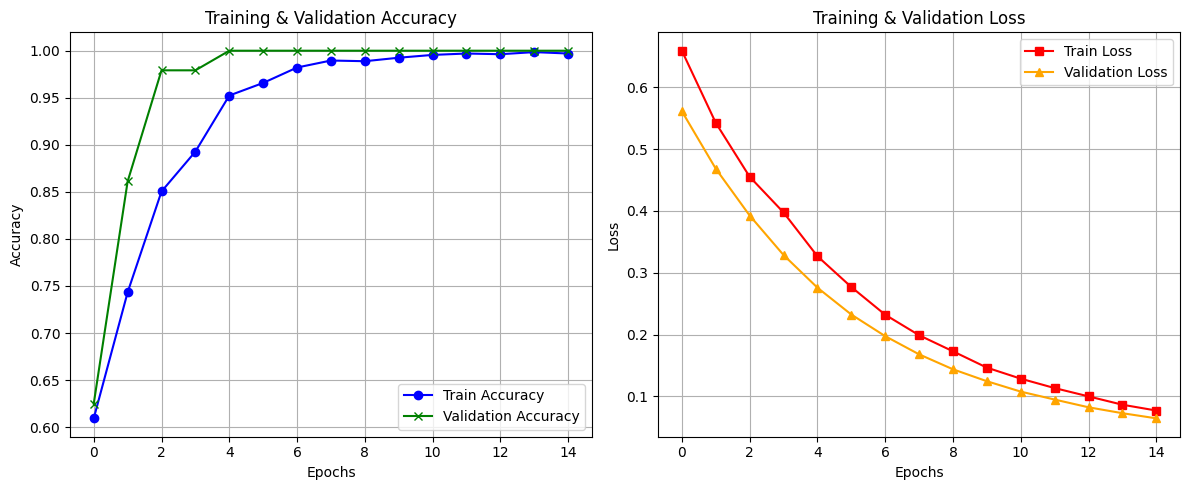

In [16]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_vgg.history["accuracy"], label="Train Accuracy", marker='o', color='b')
plt.plot(history_vgg.history["val_accuracy"], label="Validation Accuracy", marker='x', color='g')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training & Validation Accuracy")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_vgg.history["loss"], label="Train Loss", marker='s', color='r')
plt.plot(history_vgg.history["val_loss"], label="Validation Loss", marker='^', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss")
plt.grid(True)

plt.tight_layout()
plt.show()


In [17]:
test_loss, test_acc = model_vgg.evaluate(test_generator, verbose=1)
print(f"\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

y_true = test_generator.classes

test_generator.reset()

y_pred_probs = model_vgg.predict(test_generator, verbose=1)

y_pred = (y_pred_probs > 0.5).astype(int).flatten()


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - accuracy: 1.0000 - loss: 0.0601

Test Loss: 0.0637, Test Accuracy: 1.0000
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 223ms/step



Test Set Classification Report:
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       172
        PCOS       1.00      1.00      1.00       117

    accuracy                           1.00       289
   macro avg       1.00      1.00      1.00       289
weighted avg       1.00      1.00      1.00       289



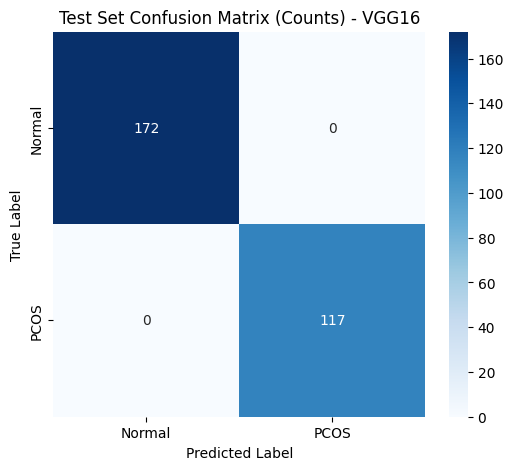

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step - accuracy: 1.0000 - loss: 0.0661

Validation Loss: 0.0647, Validation Accuracy: 100.00%
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step

Validation Set Classification Report:
              precision    recall  f1-score   support

      Normal       0.58      0.58      0.58       171
        PCOS       0.39      0.39      0.39       117

    accuracy                           0.51       288
   macro avg       0.49      0.49      0.49       288
weighted avg       0.51      0.51      0.51       288



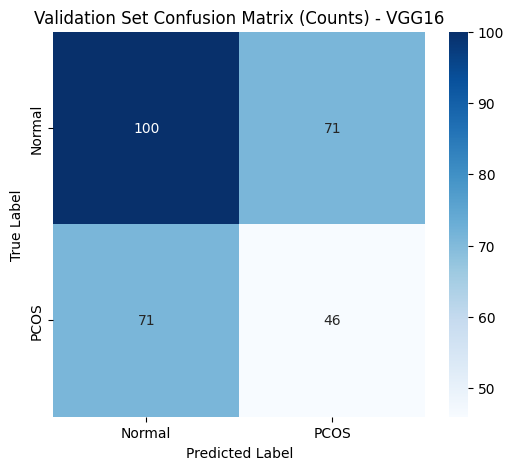

In [18]:
print("\nTest Set Classification Report:")

y_test_true = test_generator.classes
test_generator.reset()

y_test_pred_probs = model_vgg.predict(test_generator, verbose=1)
y_test_pred = (y_test_pred_probs > 0.5).astype(int).flatten()

print(classification_report(y_test_true, y_test_pred, target_names=['Normal', 'PCOS']))

cm_test = confusion_matrix(y_test_true, y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues",
             xticklabels=['Normal', 'PCOS'], yticklabels=['Normal', 'PCOS'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Test Set Confusion Matrix (Counts) - VGG16")
plt.show()

val_loss, val_acc = model_vgg.evaluate(valid_generator, verbose=1)
print(f"\nValidation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc * 100:.2f}%")

y_val_true = valid_generator.classes
valid_generator.reset()

y_val_pred_probs = model_vgg.predict(valid_generator, verbose=1)
y_val_pred = (y_val_pred_probs > 0.5).astype(int).flatten()

print("\nValidation Set Classification Report:")
print(classification_report(y_val_true, y_val_pred, target_names=['Normal', 'PCOS']))

cm_val = confusion_matrix(y_val_true, y_val_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_val, annot=True, fmt="d", cmap="Blues",
             xticklabels=['Normal', 'PCOS'], yticklabels=['Normal', 'PCOS'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Validation Set Confusion Matrix (Counts) - VGG16")
plt.show()


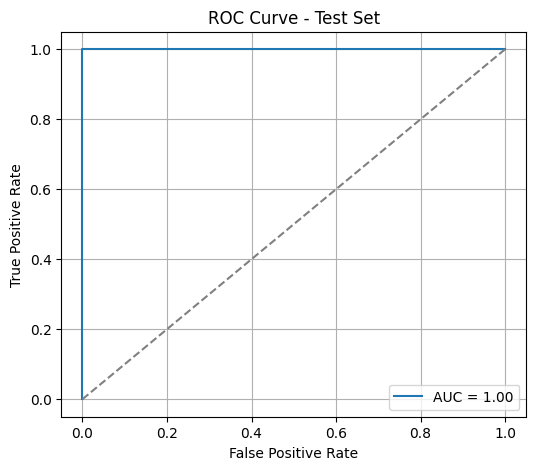

Sensitivity (Recall for PCOS): 1.00
Specificity (Recall for Normal): 1.00


In [19]:
fpr, tpr, _ = roc_curve(y_test_true, y_test_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Test Set")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

cm = confusion_matrix(y_test_true, (y_test_pred_probs > 0.5).astype(int).flatten())

tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
specificity = tn / (tn + fp) if (tn + fp) != 0 else 0

print(f"Sensitivity (Recall for PCOS): {sensitivity:.2f}")
print(f"Specificity (Recall for Normal): {specificity:.2f}")


In [20]:
#MobileNetV2

In [21]:
IMG_SIZE = (224, 224, 3)
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=IMG_SIZE)

for layer in base_model.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(1, activation="sigmoid")(x)

model_mobilenet = Model(inputs=base_model.input, outputs=output)

model_mobilenet.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint("best_mobilenet_model.h5", save_best_only=True, monitor="val_loss")
]

history_mobile = model_mobilenet.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=15,
    callbacks=callbacks,
    verbose=1
)

test_loss, test_acc = model_mobilenet.evaluate(test_generator, verbose=1)
print(f"\n Final Test Accuracy: {test_acc * 100:.2f}%")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7003 - loss: 0.5761

42/42 ━━━━━━━━━━━━━━━━━━━━ 17s 178ms/step - accuracy: 0.7034 - loss: 0.5711 - val_accuracy: 1.0000 - val_loss: 0.0759
Epoch 2/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9831 - loss: 0.0895

42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9833 - loss: 0.0891 - val_accuracy: 1.0000 - val_loss: 0.0237
Epoch 3/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 0.0348

42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 1.0000 - loss: 0.0347 - val_accuracy: 1.0000 - val_loss: 0.0120
Epoch 4/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 0.0188

42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 1.0000 - loss: 0.0188 - val_accuracy: 1.0000 - val_loss: 0.0070
Epoch 5/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.0118

42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 1.0000 - loss: 0.0118 - val_accuracy: 1.0000 - val_loss: 0.0044
Epoch 6/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0088

42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 1.0000 - loss: 0.0088 - val_accuracy: 1.0000 - val_loss: 0.0030
Epoch 7/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 0.0065

42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 1.0000 - loss: 0.0065 - val_accuracy: 1.0000 - val_loss: 0.0022
Epoch 8/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0064

42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 1.0000 - loss: 0.0064 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 9/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 0.0033

42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 1.0000 - loss: 0.0033 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 10/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 0.0030

42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 1.0000 - loss: 0.0030 - val_accuracy: 1.0000 - val_loss: 0.0010
Epoch 11/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 0.0028

42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 1.0000 - loss: 0.0028 - val_accuracy: 1.0000 - val_loss: 8.2513e-04
Epoch 12/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 0.0027

42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 1.0000 - val_loss: 7.1512e-04
Epoch 13/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 0.0022

42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 1.0000 - val_loss: 5.9380e-04
Epoch 14/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.0015

42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 1.0000 - val_loss: 5.1524e-04
Epoch 15/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 0.0014

42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 4.5255e-04
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 299ms/step - accuracy: 1.0000 - loss: 6.4492e-04

 Final Test Accuracy: 100.00%


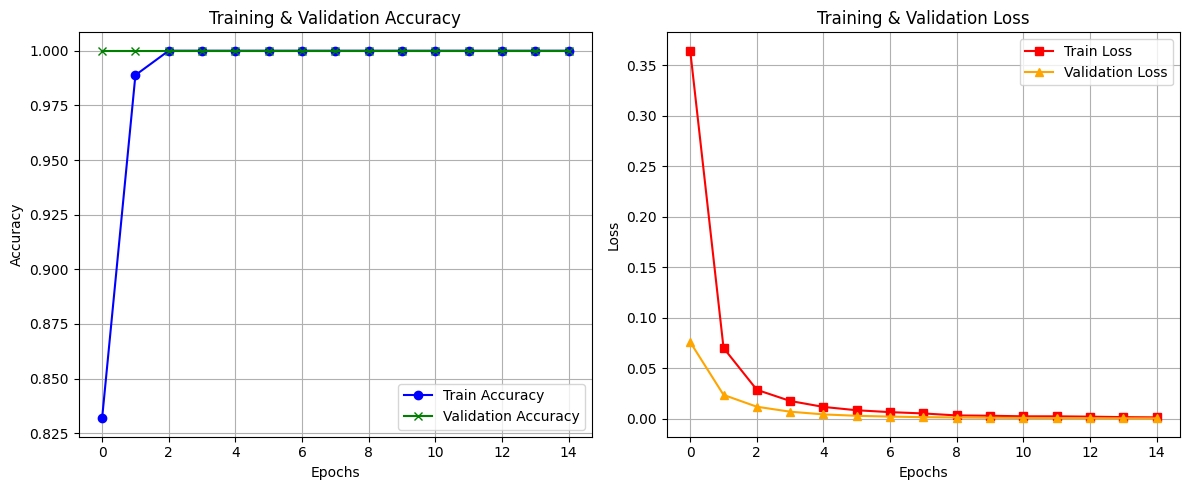

In [22]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_mobile.history["accuracy"], label="Train Accuracy", marker='o', color='b')
plt.plot(history_mobile.history["val_accuracy"], label="Validation Accuracy", marker='x', color='g')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_mobile.history["loss"], label="Train Loss", marker='s', color='r')
plt.plot(history_mobile.history["val_loss"], label="Validation Loss", marker='^', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [23]:
test_loss, test_acc = model_mobilenet.evaluate(test_generator, verbose=1)
print(f"\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

y_true = test_generator.classes

test_generator.reset()

y_pred_probs = model_mobilenet.predict(test_generator, verbose=1)

y_pred = (y_pred_probs > 0.5).astype(int).flatten()


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 1.0000 - loss: 6.4492e-04

Test Loss: 0.0009, Test Accuracy: 1.0000
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 353ms/step



Test Set Classification Report:
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       172
        PCOS       1.00      1.00      1.00       117

    accuracy                           1.00       289
   macro avg       1.00      1.00      1.00       289
weighted avg       1.00      1.00      1.00       289



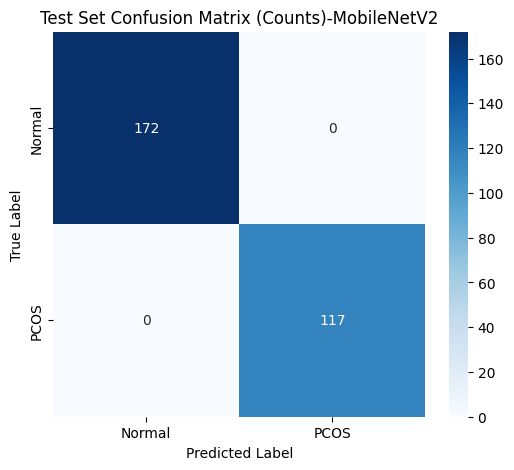

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 4.3158e-04

Validation Loss: 0.0005, Validation Accuracy: 100.00%
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step

Validation Set Classification Report:
              precision    recall  f1-score   support

      Normal       0.58      0.58      0.58       171
        PCOS       0.38      0.38      0.38       117

    accuracy                           0.50       288
   macro avg       0.48      0.48      0.48       288
weighted avg       0.50      0.50      0.50       288



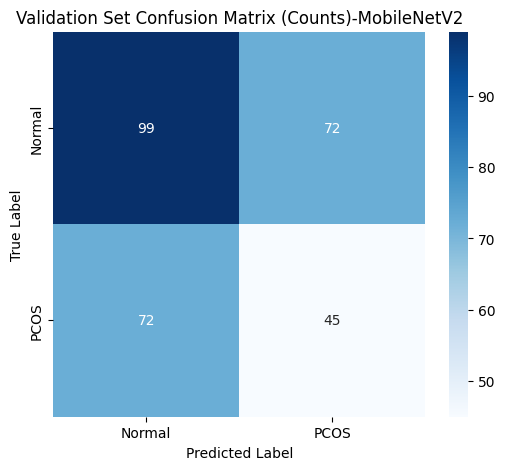

In [24]:
print("\nTest Set Classification Report:")

y_test_true = test_generator.classes

test_generator.reset()

y_test_pred_probs = model_mobilenet.predict(test_generator, verbose=1)

y_test_pred = (y_test_pred_probs > 0.5).astype(int).flatten()

print(classification_report(y_test_true, y_test_pred, target_names=['Normal', 'PCOS']))

cm_test = confusion_matrix(y_test_true, y_test_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'PCOS'], yticklabels=['Normal', 'PCOS'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Test Set Confusion Matrix (Counts)-MobileNetV2")
plt.show()

val_loss, val_acc = model_mobilenet.evaluate(valid_generator, verbose=1)
print(f"\nValidation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc * 100:.2f}%")

y_val_true = valid_generator.classes

valid_generator.reset()

y_val_pred_probs = model_mobilenet.predict(valid_generator, verbose=1)
y_val_pred = (y_val_pred_probs > 0.5).astype(int).flatten()

print("\nValidation Set Classification Report:")
print(classification_report(y_val_true, y_val_pred, target_names=['Normal', 'PCOS']))

cm_val = confusion_matrix(y_val_true, y_val_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_val, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'PCOS'], yticklabels=['Normal', 'PCOS'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Validation Set Confusion Matrix (Counts)-MobileNetV2")
plt.show()

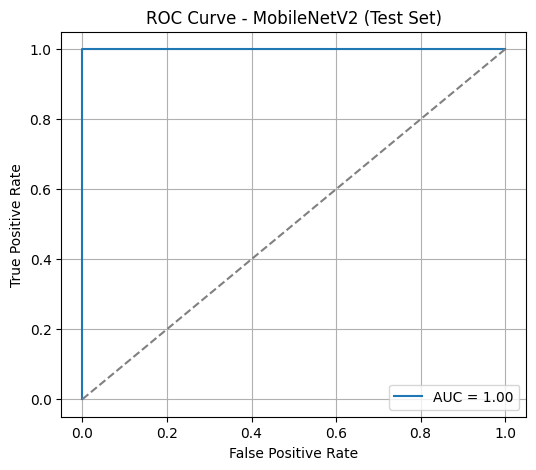

Sensitivity (Recall for PCOS): 1.00
Specificity (Recall for Normal): 1.00


In [25]:
fpr, tpr, _ = roc_curve(y_test_true, y_test_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - MobileNetV2 (Test Set)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

cm = confusion_matrix(y_test_true, (y_test_pred_probs > 0.5).astype(int).flatten())

tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
specificity = tn / (tn + fp) if (tn + fp) != 0 else 0

print(f"Sensitivity (Recall for PCOS): {sensitivity:.2f}")
print(f"Specificity (Recall for Normal): {specificity:.2f}")

In [26]:
#ResNet50

In [27]:
IMG_SIZE = (224, 224, 3)
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=IMG_SIZE)

for layer in base_model.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation="relu")(x)
x = Dropout(0.4)(x)
output = Dense(1, activation="sigmoid")(x)

model_resnet = Model(inputs=base_model.input, outputs=output)

model_resnet.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint("best_resnet_model.h5", save_best_only=True, monitor="val_loss")
]

history_resnet50 = model_resnet.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=15,
    callbacks=callbacks,
    verbose=1
)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.5345 - loss: 0.7436

42/42 ━━━━━━━━━━━━━━━━━━━━ 22s 223ms/step - accuracy: 0.5356 - loss: 0.7425 - val_accuracy: 0.5938 - val_loss: 0.6431
Epoch 2/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.6044 - loss: 0.6662

42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.6048 - loss: 0.6658 - val_accuracy: 0.6840 - val_loss: 0.5735
Epoch 3/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.6886 - loss: 0.6259

42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.6894 - loss: 0.6253 - val_accuracy: 0.7257 - val_loss: 0.5326
Epoch 4/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.7502 - loss: 0.5516

42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.7507 - loss: 0.5512 - val_accuracy: 0.7569 - val_loss: 0.4958
Epoch 5/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.8043 - loss: 0.4971

42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.8049 - loss: 0.4970 - val_accuracy: 0.9097 - val_loss: 0.4506
Epoch 6/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.8738 - loss: 0.4698

42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.8737 - loss: 0.4696 - val_accuracy: 0.9375 - val_loss: 0.4185
Epoch 7/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.8728 - loss: 0.4303

42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.8730 - loss: 0.4300 - val_accuracy: 0.8681 - val_loss: 0.3909
Epoch 8/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9045 - loss: 0.3914

42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.9046 - loss: 0.3914 - val_accuracy: 0.9375 - val_loss: 0.3570
Epoch 9/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9083 - loss: 0.3701

42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.9086 - loss: 0.3697 - val_accuracy: 0.9340 - val_loss: 0.3307
Epoch 10/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9205 - loss: 0.3289

42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.9205 - loss: 0.3289 - val_accuracy: 0.9757 - val_loss: 0.3169
Epoch 11/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9303 - loss: 0.3196

42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.9302 - loss: 0.3195 - val_accuracy: 0.9201 - val_loss: 0.2894
Epoch 12/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9328 - loss: 0.2958

42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.9329 - loss: 0.2956 - val_accuracy: 0.9549 - val_loss: 0.2680
Epoch 13/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9270 - loss: 0.2834

42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.9273 - loss: 0.2831 - val_accuracy: 0.9444 - val_loss: 0.2514
Epoch 14/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9332 - loss: 0.2628

42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.9333 - loss: 0.2627 - val_accuracy: 0.9722 - val_loss: 0.2378
Epoch 15/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9490 - loss: 0.2515

42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.9490 - loss: 0.2513 - val_accuracy: 0.9375 - val_loss: 0.2257


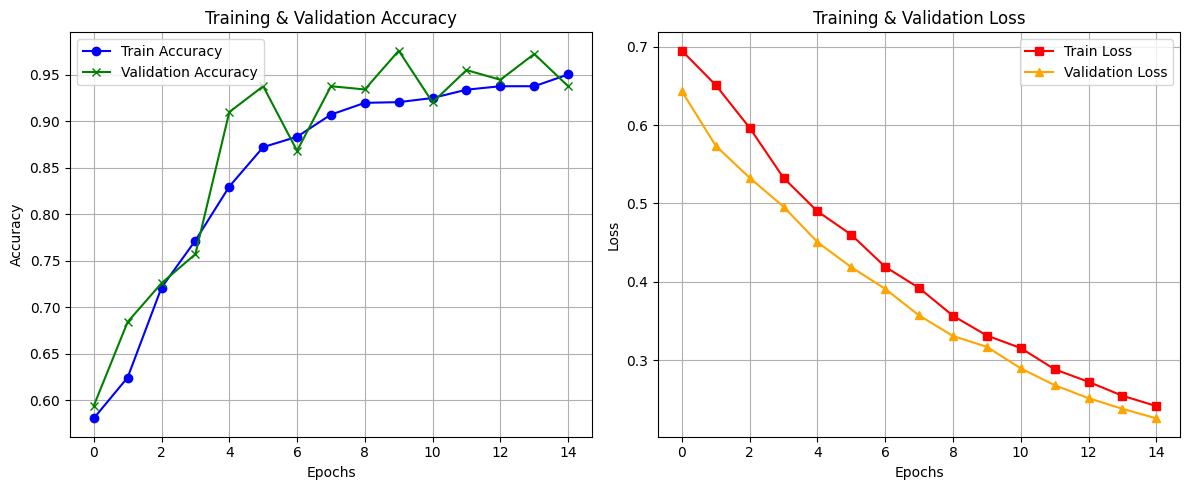

In [28]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_resnet50.history["accuracy"], label="Train Accuracy", marker='o', color='b')
plt.plot(history_resnet50.history["val_accuracy"], label="Validation Accuracy", marker='x', color='g')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training & Validation Accuracy")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_resnet50.history["loss"], label="Train Loss", marker='s', color='r')
plt.plot(history_resnet50.history["val_loss"], label="Validation Loss", marker='^', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss")
plt.grid(True)

plt.tight_layout()
plt.show()

In [29]:
test_generator.reset()

test_loss, test_acc = model_resnet.evaluate(test_generator, verbose=1)
print(f"\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

y_true = test_generator.classes

y_pred_probs = model_resnet.predict(test_generator, verbose=1)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 322ms/step - accuracy: 0.9685 - loss: 0.1825

Test Loss: 0.2423, Test Accuracy: 0.9273
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 440ms/step



Test Set Classification Report:
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step
              precision    recall  f1-score   support

      Normal       0.89      1.00      0.94       172
        PCOS       1.00      0.82      0.90       117

    accuracy                           0.93       289
   macro avg       0.95      0.91      0.92       289
weighted avg       0.94      0.93      0.93       289



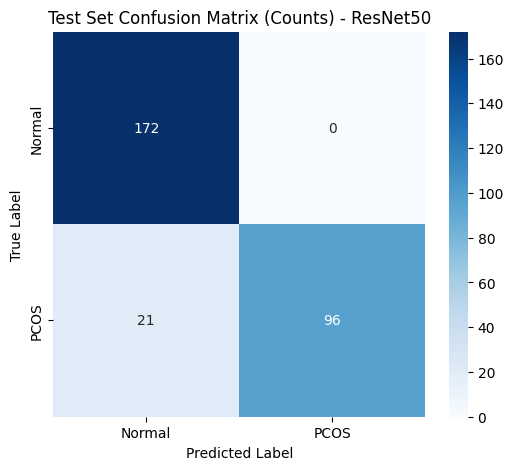

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.9455 - loss: 0.2127

Validation Loss: 0.2257, Validation Accuracy: 93.75%
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step

Validation Set Classification Report:
              precision    recall  f1-score   support

      Normal       0.59      0.65      0.62       171
        PCOS       0.40      0.34      0.37       117

    accuracy                           0.53       288
   macro avg       0.50      0.50      0.50       288
weighted avg       0.52      0.53      0.52       288



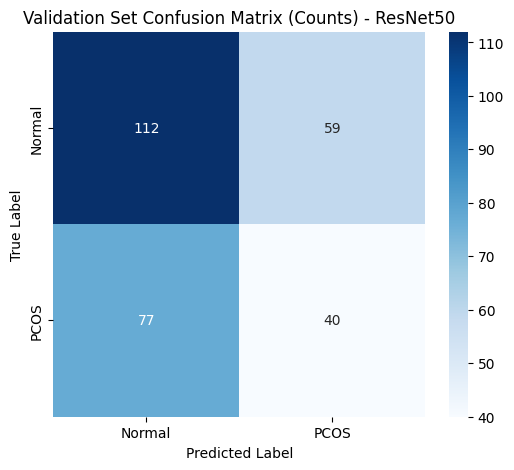

In [30]:
print("\nTest Set Classification Report:")

y_test_true = test_generator.classes
test_generator.reset()

y_test_pred_probs = model_resnet.predict(test_generator, verbose=1)
y_test_pred = (y_test_pred_probs > 0.5).astype(int).flatten()

print(classification_report(y_test_true, y_test_pred, target_names=['Normal', 'PCOS']))

cm_test = confusion_matrix(y_test_true, y_test_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'PCOS'], yticklabels=['Normal', 'PCOS'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Test Set Confusion Matrix (Counts) - ResNet50")
plt.show()

val_loss, val_acc = model_resnet.evaluate(valid_generator, verbose=1)
print(f"\nValidation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc * 100:.2f}%")

y_val_true = valid_generator.classes
valid_generator.reset()

y_val_pred_probs = model_resnet.predict(valid_generator, verbose=1)
y_val_pred = (y_val_pred_probs > 0.5).astype(int).flatten()

print("\nValidation Set Classification Report:")
print(classification_report(y_val_true, y_val_pred, target_names=['Normal', 'PCOS']))

cm_val = confusion_matrix(y_val_true, y_val_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_val, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'PCOS'], yticklabels=['Normal', 'PCOS'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Validation Set Confusion Matrix (Counts) - ResNet50")
plt.show()

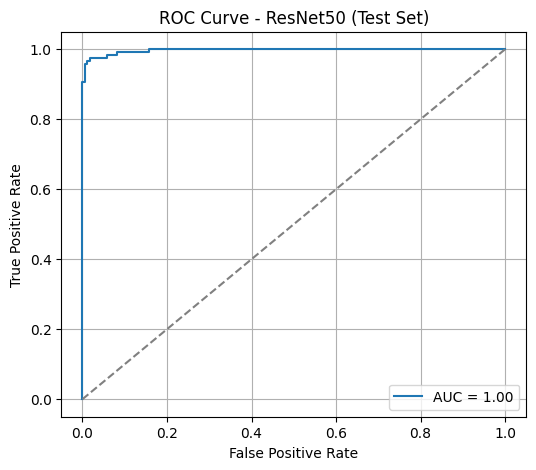

Sensitivity (Recall for PCOS): 0.82
Specificity (Recall for Normal): 1.00


In [31]:
fpr, tpr, _ = roc_curve(y_test_true, y_test_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - ResNet50 (Test Set)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

cm = confusion_matrix(y_test_true, (y_test_pred_probs > 0.5).astype(int).flatten())

tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
specificity = tn / (tn + fp) if (tn + fp) != 0 else 0

print(f"Sensitivity (Recall for PCOS): {sensitivity:.2f}")
print(f"Specificity (Recall for Normal): {specificity:.2f}")

In [32]:
#InceptionV3

In [33]:
base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.3)(x)
output_layer = Dense(1, activation="sigmoid")(x)

model_inception = Model(inputs=base_model.input, outputs=output_layer)

model_inception.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint("best_inception_model.h5", save_best_only=True, monitor="val_loss")
]

history_inception = model_inception.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=15,
    callbacks=callbacks,
    verbose=1
)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.8742 - loss: 0.3257

42/42 ━━━━━━━━━━━━━━━━━━━━ 29s 278ms/step - accuracy: 0.8759 - loss: 0.3213 - val_accuracy: 0.9965 - val_loss: 0.0063
Epoch 2/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9940 - loss: 0.0335

42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9940 - loss: 0.0334 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 3/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9908 - loss: 0.0338

42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 0.9909 - loss: 0.0336 - val_accuracy: 1.0000 - val_loss: 1.8578e-07
Epoch 4/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.9988 - loss: 0.0044 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 5/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.9977 - loss: 0.0072 - val_accuracy: 1.0000 - val_loss: 4.1008e-06
Epoch 6/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9978 - loss: 0.0056

42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9977 - loss: 0.0056 - val_accuracy: 1.0000 - val_loss: 1.1722e-07
Epoch 7/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 1.0000 - loss: 2.0178e-04 - val_accuracy: 1.0000 - val_loss: 2.9066e-07
Epoch 8/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.9998 - loss: 7.4310e-04 - val_accuracy: 1.0000 - val_loss: 6.3265e-04
Epoch 9/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.9986 - loss: 0.0018 - val_accuracy: 1.0000 - val_loss: 3.0517e-06
Epoch 10/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 1.0000 - loss: 1.3217e-04 - val_accuracy: 1.0000 - val_loss: 3.4095e-07
Epoch 11/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.9961 - loss: 0.0223 - val_accuracy: 1.0000 - val_loss: 1.1280e-06


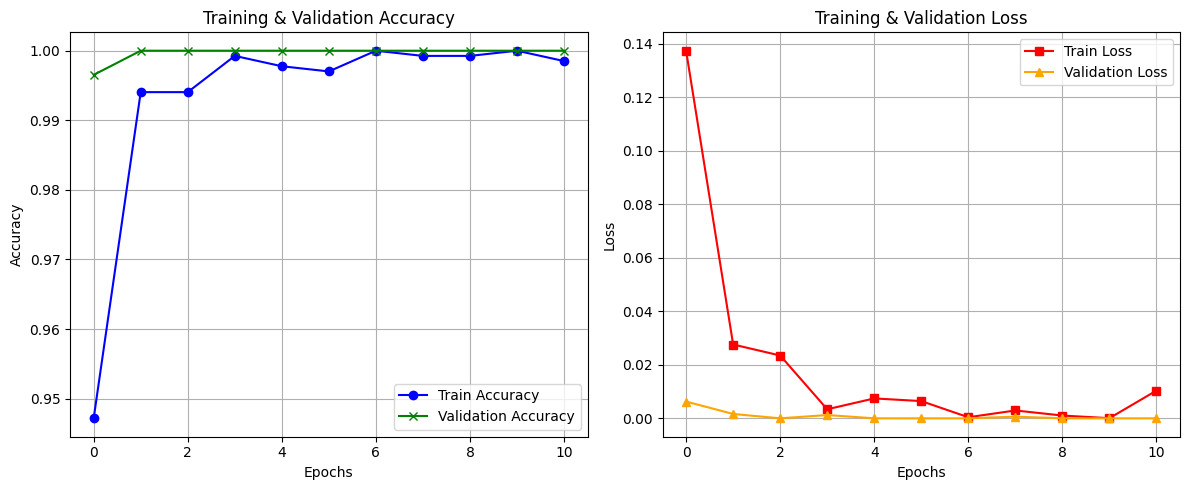

In [34]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_inception.history["accuracy"], label="Train Accuracy", marker='o', color='b')
plt.plot(history_inception.history["val_accuracy"], label="Validation Accuracy", marker='x', color='g')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_inception.history["loss"], label="Train Loss", marker='s', color='r')
plt.plot(history_inception.history["val_loss"], label="Validation Loss", marker='^', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [35]:
test_generator.reset()

test_loss, test_acc = model_inception.evaluate(test_generator, verbose=1)
print(f"\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

y_true = test_generator.classes

y_pred_probs = model_inception.predict(test_generator, verbose=1)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 532ms/step - accuracy: 1.0000 - loss: 3.6143e-08

Test Loss: 0.0000, Test Accuracy: 1.0000
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 618ms/step



Test Set Classification Report:
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       172
        PCOS       1.00      1.00      1.00       117

    accuracy                           1.00       289
   macro avg       1.00      1.00      1.00       289
weighted avg       1.00      1.00      1.00       289



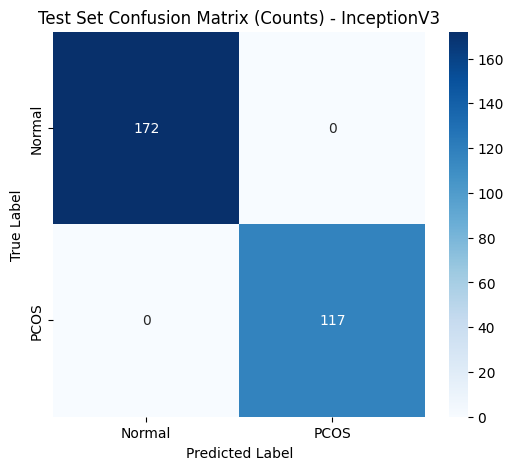

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 2.7332e-08

Validation Loss: 0.0000, Validation Accuracy: 100.00%
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step

Validation Set Classification Report:
              precision    recall  f1-score   support

      Normal       0.57      0.57      0.57       171
        PCOS       0.38      0.38      0.38       117

    accuracy                           0.49       288
   macro avg       0.47      0.47      0.47       288
weighted avg       0.49      0.49      0.49       288



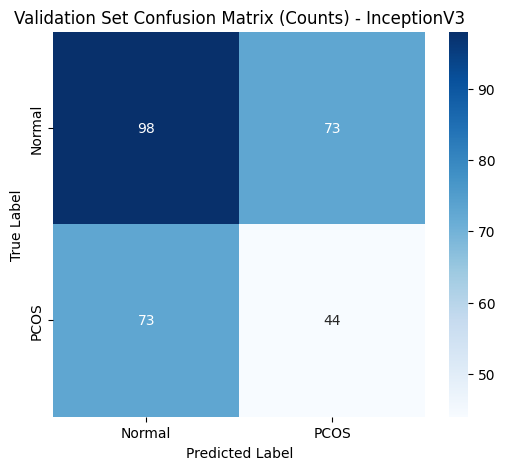

In [36]:
print("\nTest Set Classification Report:")

y_test_true = test_generator.classes
test_generator.reset()

y_test_pred_probs = model_inception.predict(test_generator, verbose=1)
y_test_pred = (y_test_pred_probs > 0.5).astype(int).flatten()

print(classification_report(y_test_true, y_test_pred, target_names=['Normal', 'PCOS']))

cm_test = confusion_matrix(y_test_true, y_test_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'PCOS'], yticklabels=['Normal', 'PCOS'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Test Set Confusion Matrix (Counts) - InceptionV3")
plt.show()

val_loss, val_acc = model_inception.evaluate(valid_generator, verbose=1)
print(f"\nValidation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc * 100:.2f}%")

y_val_true = valid_generator.classes
valid_generator.reset()

y_val_pred_probs = model_inception.predict(valid_generator, verbose=1)
y_val_pred = (y_val_pred_probs > 0.5).astype(int).flatten()

print("\nValidation Set Classification Report:")
print(classification_report(y_val_true, y_val_pred, target_names=['Normal', 'PCOS']))

cm_val = confusion_matrix(y_val_true, y_val_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_val, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'PCOS'], yticklabels=['Normal', 'PCOS'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Validation Set Confusion Matrix (Counts) - InceptionV3")
plt.show()

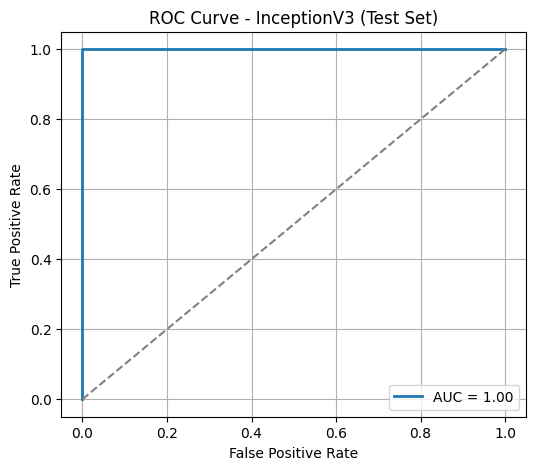

Sensitivity (Recall for PCOS): 1.00
Specificity (Recall for Normal): 1.00


In [37]:
fpr, tpr, _ = roc_curve(y_test_true, y_test_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - InceptionV3 (Test Set)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

cm = confusion_matrix(y_test_true, (y_test_pred_probs > 0.5).astype(int).flatten())

tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
specificity = tn / (tn + fp) if (tn + fp) != 0 else 0

print(f"Sensitivity (Recall for PCOS): {sensitivity:.2f}")
print(f"Specificity (Recall for Normal): {specificity:.2f}")

In [38]:
#DenseNet121

In [39]:
base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.3)(x)
output_layer = Dense(1, activation="sigmoid")(x)

model_DenseNet121 = Model(inputs=base_model.input, outputs=output_layer)

model_DenseNet121.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint("best_densenet_model.h5", save_best_only=True, monitor="val_loss")
]

history_DenseNet121 = model_DenseNet121.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=15,
    callbacks=callbacks,
    verbose=1
)


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.8806 - loss: 0.3016

42/42 ━━━━━━━━━━━━━━━━━━━━ 43s 389ms/step - accuracy: 0.8822 - loss: 0.2978 - val_accuracy: 1.0000 - val_loss: 2.7675e-06
Epoch 2/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9981 - loss: 0.0069

42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.9981 - loss: 0.0069 - val_accuracy: 1.0000 - val_loss: 1.7640e-07
Epoch 3/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - accuracy: 0.9985 - loss: 0.0046 - val_accuracy: 1.0000 - val_loss: 1.4105e-05
Epoch 4/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9994 - loss: 0.0024

42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 0.9994 - loss: 0.0024 - val_accuracy: 1.0000 - val_loss: 2.1838e-08
Epoch 5/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 1.0000 - loss: 6.4874e-04

42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 1.0000 - loss: 6.4373e-04 - val_accuracy: 1.0000 - val_loss: 5.1567e-09
Epoch 6/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 1.0000 - loss: 2.3079e-04

42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 1.0000 - loss: 2.3222e-04 - val_accuracy: 1.0000 - val_loss: 7.8715e-10
Epoch 7/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.9999 - loss: 1.3123e-04 - val_accuracy: 1.0000 - val_loss: 3.2359e-08
Epoch 8/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.9996 - loss: 0.0016 - val_accuracy: 1.0000 - val_loss: 1.9939e-08
Epoch 9/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.9991 - loss: 0.0040 - val_accuracy: 1.0000 - val_loss: 1.9440e-06
Epoch 10/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 4.2273e-08
Epoch 11/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.9977 - loss: 0.0079 - val_accuracy: 1.0000 - val_loss: 1.4186e-09


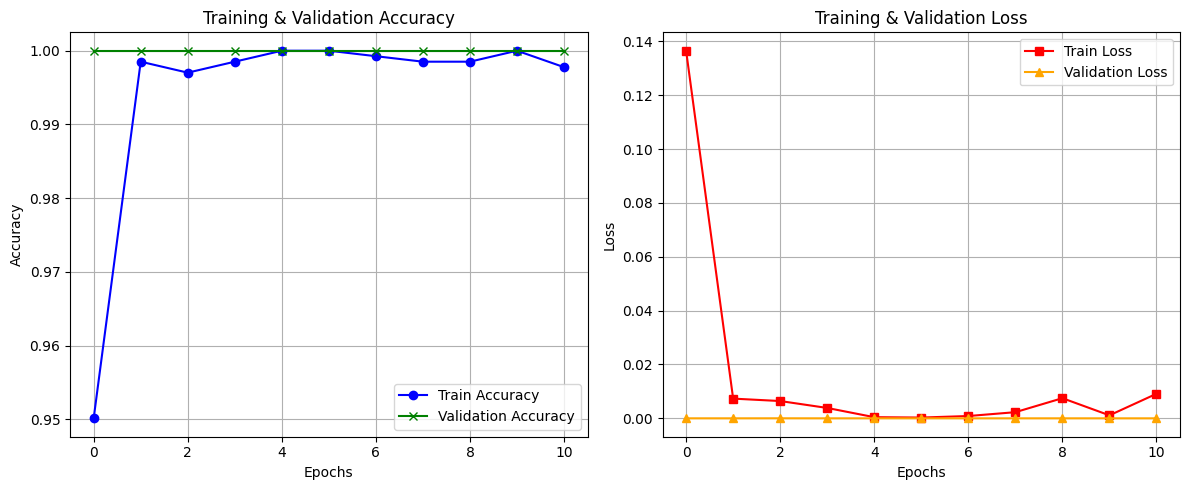

In [40]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_DenseNet121.history["accuracy"], label="Train Accuracy", marker='o', color='b')
plt.plot(history_DenseNet121.history["val_accuracy"], label="Validation Accuracy", marker='x', color='g')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_DenseNet121.history["loss"], label="Train Loss", marker='s', color='r')
plt.plot(history_DenseNet121.history["val_loss"], label="Validation Loss", marker='^', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [41]:
test_generator.reset()

test_loss, test_acc = model_DenseNet121.evaluate(test_generator, verbose=1)
print(f"\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

y_true = test_generator.classes

y_pred_probs = model_DenseNet121.predict(test_generator, verbose=1)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 831ms/step - accuracy: 1.0000 - loss: 4.2923e-10

Test Loss: 0.0000, Test Accuracy: 1.0000
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step



Test Set Classification Report:
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       172
        PCOS       1.00      1.00      1.00       117

    accuracy                           1.00       289
   macro avg       1.00      1.00      1.00       289
weighted avg       1.00      1.00      1.00       289



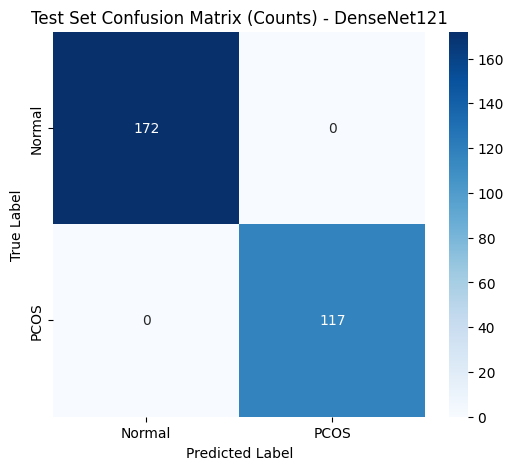

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 3.9845e-10

Validation Loss: 0.0000, Validation Accuracy: 100.00%
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step

Validation Set Classification Report:
              precision    recall  f1-score   support

      Normal       0.59      0.59      0.59       171
        PCOS       0.40      0.40      0.40       117

    accuracy                           0.51       288
   macro avg       0.50      0.50      0.50       288
weighted avg       0.51      0.51      0.51       288



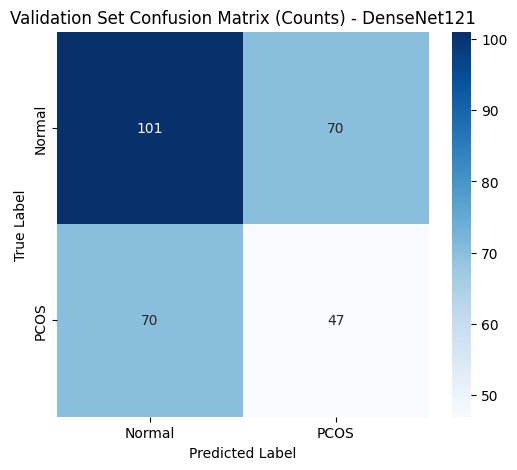

In [42]:
print("\nTest Set Classification Report:")

y_test_true = test_generator.classes
test_generator.reset()

y_test_pred_probs = model_DenseNet121.predict(test_generator, verbose=1)
y_test_pred = (y_test_pred_probs > 0.5).astype(int).flatten()

print(classification_report(y_test_true, y_test_pred, target_names=['Normal', 'PCOS']))

cm_test = confusion_matrix(y_test_true, y_test_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'PCOS'], yticklabels=['Normal', 'PCOS'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Test Set Confusion Matrix (Counts) - DenseNet121")
plt.show()

val_loss, val_acc = model_DenseNet121.evaluate(valid_generator, verbose=1)
print(f"\nValidation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc * 100:.2f}%")

y_val_true = valid_generator.classes
valid_generator.reset()

y_val_pred_probs = model_DenseNet121.predict(valid_generator, verbose=1)
y_val_pred = (y_val_pred_probs > 0.5).astype(int).flatten()

print("\nValidation Set Classification Report:")
print(classification_report(y_val_true, y_val_pred, target_names=['Normal', 'PCOS']))

cm_val = confusion_matrix(y_val_true, y_val_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_val, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'PCOS'], yticklabels=['Normal', 'PCOS'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Validation Set Confusion Matrix (Counts) - DenseNet121")
plt.show()

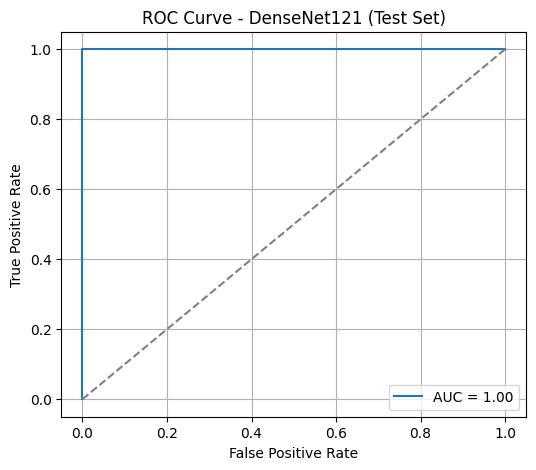

Sensitivity (Recall for PCOS): 1.00
Specificity (Recall for Normal): 1.00


In [43]:
fpr, tpr, _ = roc_curve(y_test_true, y_test_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - DenseNet121 (Test Set)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

cm = confusion_matrix(y_test_true, (y_test_pred_probs > 0.5).astype(int).flatten())

tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
specificity = tn / (tn + fp) if (tn + fp) != 0 else 0

print(f"Sensitivity (Recall for PCOS): {sensitivity:.2f}")
print(f"Specificity (Recall for Normal): {specificity:.2f}")

In [44]:
test_results = {}

for model_name, model_instance in {
    "VGG16": model_vgg,
    "MobileNetV2": model_mobilenet,
    "ResNet50": model_resnet,
    "InceptionV3": model_inception,
    "DenseNet121": model_DenseNet121
}.items():
    test_generator.reset()
    result = model_instance.evaluate(test_generator, verbose=1)
    test_results[model_name] = result

print("\nTest Accuracy and Loss for Each Model:")
for model, result in test_results.items():
    print(f"{model}: Loss = {result[0]:.4f}, Accuracy = {result[1]:.4f}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - accuracy: 1.0000 - loss: 0.0601
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 1.0000 - loss: 6.4492e-04
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.9685 - loss: 0.1825
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 3.6143e-08
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 1.0000 - loss: 4.2923e-10

Test Accuracy and Loss for Each Model:
VGG16: Loss = 0.0637, Accuracy = 1.0000
MobileNetV2: Loss = 0.0009, Accuracy = 1.0000
ResNet50: Loss = 0.2423, Accuracy = 0.9273
InceptionV3: Loss = 0.0000, Accuracy = 1.0000
DenseNet121: Loss = 0.0000, Accuracy = 1.0000


In [45]:
train_accuracies = {
    "VGG16": history_vgg.history['accuracy'][-1],
    "MobileNetV2": history_mobile.history['accuracy'][-1],
    "ResNet50": history_resnet50.history['accuracy'][-1],
    "InceptionV3": history_inception.history['accuracy'][-1],
    "DenseNet121": history_DenseNet121.history['accuracy'][-1],
}



print("\nTest Accuracy and Loss for Each Model:")
for model, result in test_results.items():
    print(f"{model}: Loss = {result[0]:.4f}, Accuracy = {result[1]:.4f}")

print("\nTrain Accuracy for Each Model:")
for model, acc in train_accuracies.items():
    print(f"{model}: Accuracy = {acc:.4f}")



Test Accuracy and Loss for Each Model:
VGG16: Loss = 0.0637, Accuracy = 1.0000
MobileNetV2: Loss = 0.0009, Accuracy = 1.0000
ResNet50: Loss = 0.2423, Accuracy = 0.9273
InceptionV3: Loss = 0.0000, Accuracy = 1.0000
DenseNet121: Loss = 0.0000, Accuracy = 1.0000

Train Accuracy for Each Model:
VGG16: Accuracy = 0.9970
MobileNetV2: Accuracy = 1.0000
ResNet50: Accuracy = 0.9501
InceptionV3: Accuracy = 0.9985
DenseNet121: Accuracy = 0.9978


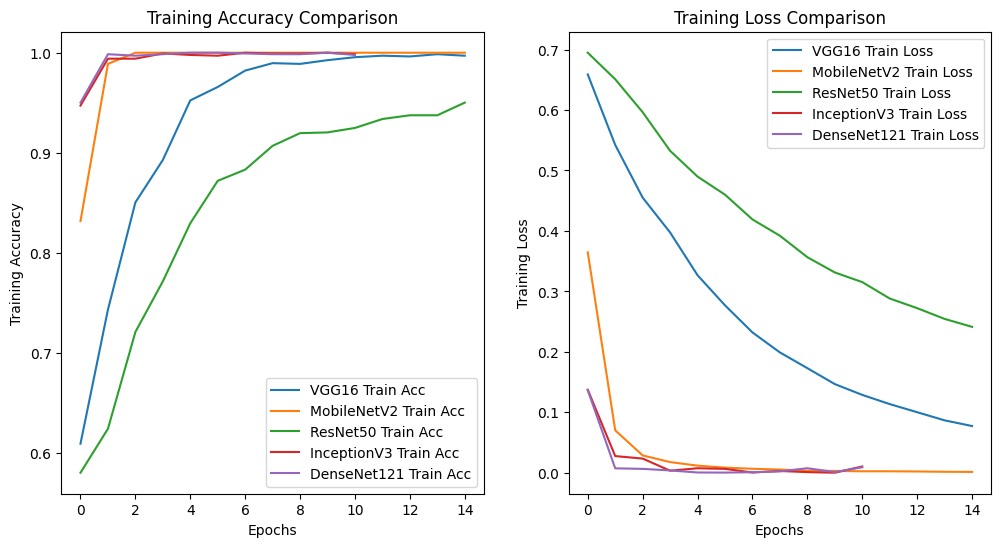

In [46]:
import matplotlib.pyplot as plt

def plot_training_curves(histories, model_names):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    for history, name in zip(histories, model_names):
        plt.plot(history.history["accuracy"], label=f"{name} Train Acc")
    plt.xlabel("Epochs")
    plt.ylabel("Training Accuracy")
    plt.legend()
    plt.title("Training Accuracy Comparison")

    # Loss
    plt.subplot(1, 2, 2)
    for history, name in zip(histories, model_names):
        plt.plot(history.history["loss"], label=f"{name} Train Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Training Loss")
    plt.legend()
    plt.title("Training Loss Comparison")

    plt.show()

plot_training_curves(
    [history_vgg, history_mobile, history_resnet50, history_inception,history_DenseNet121],
    ["VGG16", "MobileNetV2", "ResNet50", "InceptionV3","DenseNet121"]
)
